C:\Users\ghadf\AppData\Local\Temp\ipykernel_7596\2990355723.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TS%'] = data['PTS'] / (2 * (data['FGA'] + 0.44 * data['FTA']))
C:\Users\ghadf\AppData\Local\Temp\ipykernel_7596\2990355723.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Offensive_Possessions'] = data['FGA'] + 0.44 * data['FTA'] + data['TOV'] - data['OREB']
C:\Users\ghadf\AppData\Local\Temp\ipykernel_7596\2990355723.py:42: SettingWithCopyWarning: 
A value is trying to be set on 

has_23_24_schedule =  False


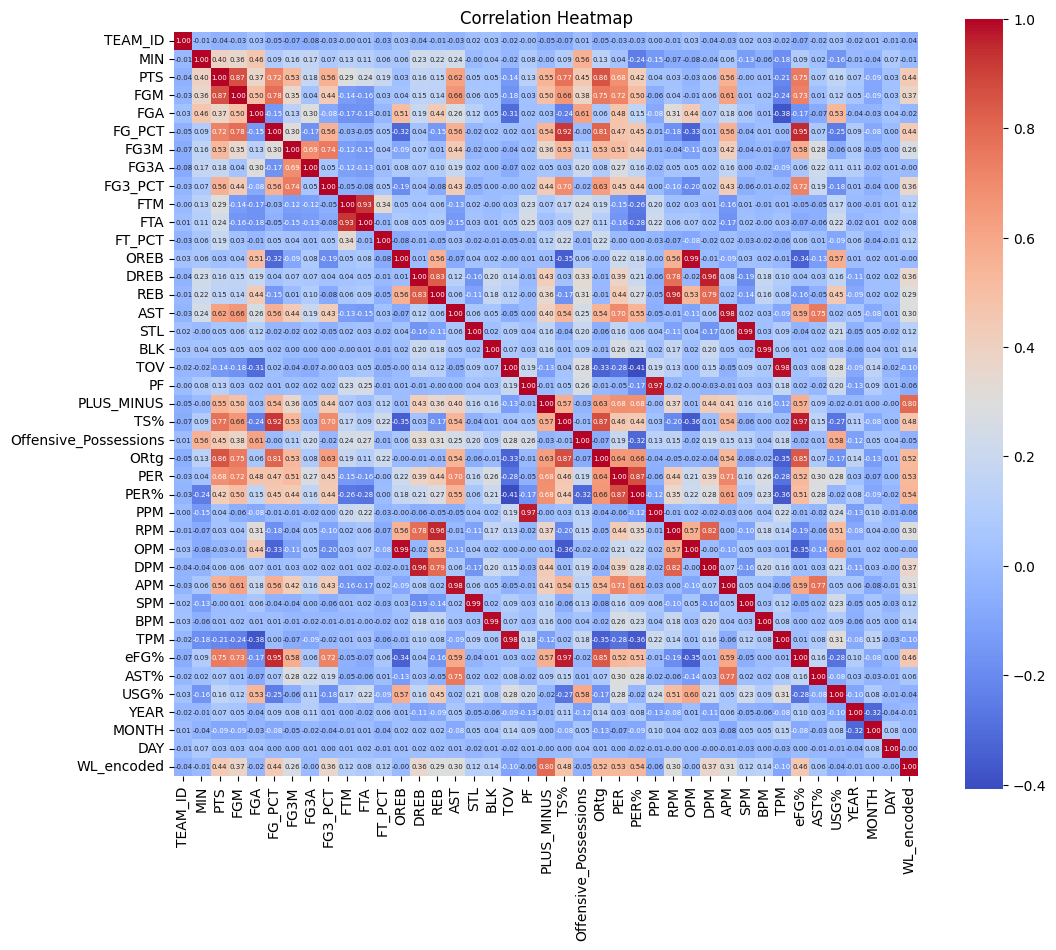

In [13]:
#todos: normalize the stats, add in the teams from 1979 on that are missing from the data,
#change just the non percentage continuous variables in the X dataset
#previous year was released on 8/17, see if in new season data are there then
#look into XGBoost for the gradient boosting regressor

from nba_api.stats.static import teams 
from nba_api.stats.endpoints import leaguegamefinder 
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

teams = teams.get_teams()
#print(teams)

# Set the option to display all columns
pd.set_option('display.max_columns', None)

all_games = leaguegamefinder.LeagueGameFinder().get_data_frames()[0]

# List of current NBA team IDs
current_teams = [1610612737, 1610612738, 1610612740, 1610612741, 1610612742, 1610612743, 1610612744, 1610612745, 1610612746, 1610612747, 1610612748, 1610612749, 1610612750, 1610612751, 1610612752, 1610612753, 1610612754, 1610612755, 1610612756, 1610612757, 1610612758, 1610612759, 1610612760, 1610612761, 1610612762, 1610612763, 1610612764, 1610612765, 1610612766]
#print(current_teams)

# Filter the data to include only current NBA teams
data = all_games[all_games['TEAM_ID'].isin(current_teams)]
#print('base_data = ',data.columns)
#print(data.head())
#stat addons list: PER, TS%, eFG%, 3PAr, FTr, ORB%, DRB%, TRB%, AST%, STL%, BLK%, TOV%, USG%, OWS, DWS, WS, WS/48, OBPM, DBPM, BPM, VORP
#adding TS%= PTS / (2 * (FGA + 0.44 * FTA))
data['TS%'] = data['PTS'] / (2 * (data['FGA'] + 0.44 * data['FTA']))



#**OFF Rating add
# Calculate offensive and defensive possessions
data['Offensive_Possessions'] = data['FGA'] + 0.44 * data['FTA'] + data['TOV'] - data['OREB']
#data['Defensive_Possessions'] = data['Opponent_FGA'] + 0.44 * data['Opponent_FTA'] + data['Opponent_TOV'] - data['Opponent_OREB']

# Calculate Offensive Rating and Defensive Rating
data['ORtg'] = (data['PTS'] / data['Offensive_Possessions']) * 100
#data['DRtg'] = (data['Points_Allowed'] / data['Defensive_Possessions']) * 100

#adding PER% = (PTS + REB + AST + STL + BLK - FGM - FTM - TOV) / MIN
data['PER'] = (data['PTS'] + data['REB'] + data['AST'] + data['STL'] + data['BLK'] -
             data['FGM'] - data['FTM'] - data['TOV'])/ data['MIN']
#standardized to 48 minutes
#data['PER%'] = (data['PER'] / data['MIN']) * 48

#adding PER% = (PTS + REB + AST + STL + BLK - FGM - FTM - TOV) / OP
data['PER%'] = (data['PER'] / data['Offensive_Possessions']) * 100

# add per min function
def per_min(col):
    # Create a new column name based on the input column's name
    column_pm = col.name[0] + 'PM'
    
    # Set the new column's values to the per-minute values of the input column
    data[column_pm] = col / data['MIN']

#add points per minute  
#data['PPM'] = data['PTS'] / data['MIN']
per_min(data['PTS'])

#adding rebounds per minute
#data['RPM'] = data['REB'] / data['MIN']
per_min(data['REB'])
per_min(data['OREB'])
per_min(data['DREB'])

#adding assists per minute
#data['APM'] = data['AST'] / data['MIN']
per_min(data['AST'])

#adding steals per minute
#data['SPM'] = data['STL'] / data['MIN']
per_min(data['STL'])

#adding blocks per minute
#data['BPM'] = data['BLK'] / data['MIN']
per_min(data['BLK'])

#adding turnovers per minute
#data['TPM'] = data['TOV'] / data['MIN']
per_min(data['TOV'])

#adding fouls per minute
#data['FPM'] = data['PF'] / data['MIN']
per_min(data['PF'])

#adding eFG%
data['eFG%'] = (data['FGM'] + 0.5 * data['FG3M']) / data['FGA']

#adding AST%
data['AST%'] = data['AST'] / data['FGM']

#adding USG%
data['USG%'] = (data['FGA'] + 0.44 * data['FTA'] + data['TOV']) / data['MIN']
#add all the percentages to the list of columns

#adding OWS
#adding DWS
#adding WS
3#adding WS/48
#adding OBPM
#adding DBPM
#adding BPM
#adding VORP
#adding O/D Rating
#adding O/D Win Shares
#adding O/D Win Shares
#adding O/D WS/48
#adding O/D BPM
#adding O/D BPM
#adding O/D VORP
#adding O/D VORP

#***PRE PROCESSING***
#*Date transformations
# Convert the date column to datetime format
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Extract numerical features from the date column
data['YEAR'] = data['GAME_DATE'].dt.year
data['MONTH'] = data['GAME_DATE'].dt.month
data['DAY'] = data['GAME_DATE'].dt.day


#**Drop Missing values
# Drop rows with missing values
data_encoded = data.dropna()

# Filter the data to include only selected columns
#data_encoded_selected = data_encoded.iloc[:, :40]

# Check if the 2022-2023 NBA season is in the data. previous year was released on 8/17, see if in data then
has_23_24_schedule = any(data_encoded['SEASON_ID'] == 42023)
print('has_23_24_schedule = ',has_23_24_schedule)


# Filter the data for the 2022-2023 NBA season - changing to 1979-2023
#could also use season_id = 42022
start_date = pd.to_datetime('1979-10-01')
end_date = pd.to_datetime('2023-06-30')
season_data = data_encoded[(data_encoded['GAME_DATE'] >= start_date) & (data_encoded['GAME_DATE'] <= end_date)].copy()

#sort season_data by game_id and game_date
#proof that the dataset is team stats per game and not combined team stats per game
season_data = season_data.sort_values(by=['GAME_DATE','GAME_ID'])


# Encode 'WL' column as 1 for 'W' (win) and 0 for 'L' (loss)
season_data['WL_encoded'] = season_data['WL'].apply(lambda x: 1 if x == 'W' else 0)
#print(season_data)


# Reorder the columns in the DataFrame to place 'WL_encoded' at the end
season_data = season_data[[col for col in season_data.columns if col != 'WL_encoded'] + ['WL_encoded']]

# Create a correlation matrix for the selected columns
correlation_matrix = season_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True,
            annot_kws={'size': 5})  # Adjust the font size (here it's set to 8)


plt.title('Correlation Heatmap')
plt.show()

#In this code, we reorder the columns of season_data so that the target variable 'WL_encoded' is at the end. 
# Then, we calculate the correlation matrix using season_data.corr() and plot the heatmap using sns.heatmap(). 
# The heatmap will show the correlation values between different variables, with positive correlations in warmer colors and negative 
# correlations in cooler colors. The annot=True parameter shows the actual correlation values on the heatmap, and fmt='.2f' formats 
# the numbers to two decimal places. The cmap='coolwarm' parameter sets the color scheme for the heatmap.


In [14]:
#PRE_PROCESSING STEP

# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define the columns for the dependent (y) and independent (X) variables
y_column = 'WL_encoded'
x_excluded_independent_variables = ['GAME_DATE','TEAM_ABBREVIATION','WL','FGA','TOV', 'TEAM_NAME','MATCHUP','GAME_ID','PPM','RPM','APM','SPM','BPM','TPM',
                                    'PER','OPM','DPM','USG%','FG3A','OREB','PF','MIN','PTS','FGM','FG3M','FTM','FTA','PTS','REB','AST','PF','STL','BLK','DREB']

# Combine y_column with x_excluded_independent_variables
columns_to_drop = [y_column] + x_excluded_independent_variables

# Separate features and target
X = season_data.drop(columns=columns_to_drop, axis=1)  # drop the dependent variable and other columns that won't be used as features
y = season_data['WL_encoded']  # Selects target_column as the target variable

#Check the data types of the features in X
#X_dtypes = X.dtypes
#print(X_dtypes)


# Handle missing values
# Get numerical and categorical features based on their data types
numerical_features = [column for column in X.columns if X[column].dtype != 'object']
categorical_features = [column for column in X.columns if X[column].dtype == 'object']

# Define numerical transformer
# A pipeline that first fills missing numerical values with the mean, then scales them to have mean=0 and variance=1
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fills missing numerical values with the mean
    ('scaler', StandardScaler())                 # Scales numerical features
])

# Define categorical transformer
# A pipeline that first fills missing categorical values with the most frequent category, then one-hot encodes them
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fills missing categorical values with the most frequent category
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    # One-hot encodes categorical features
])

# Combine numerical and categorical transformers
# Applies the numerical and categorical transformations defined above to the corresponding columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
print(X.head())
# Split data
# Splits the data into training (80%) and testing (20%) sets, with a random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing on training data
# Fits and transforms the training data using the preprocessor defined above
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Apply preprocessing on testing data
# Transforms the testing data using the same preprocessor (without fitting, to prevent data leakage)
X_test_preprocessed = preprocessor.transform(X_test)

for column in categorical_features:
    print(f"{column}: {X[column].nunique()} unique values")

# Confirm the shape of X and y after handling missing values and encoding
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

print("Shape of X_train_preprocessed:", X_train_preprocessed.shape)
print("Shape of y:", y_train.shape)


# Get the transformed feature names after preprocessing
# This extracts the names of the features after transformation from the ColumnTransformer
#feature_names_after_preprocessing = preprocessor.get_feature_names(input_features=X.columns)

# Print column names after preprocessing
#print("Column names after preprocessing:")
#print(feature_names_after_preprocessing)

      SEASON_ID     TEAM_ID  FG_PCT  FG3_PCT  FT_PCT  PLUS_MINUS       TS%  \
29997     12018  1610612763   0.413    0.219   0.765         5.0  0.509536   
29998     12018  1610612754   0.375    0.276   0.774        -5.0  0.474279   
29993     12018  1610612737   0.380    0.308   0.688       -19.0  0.504942   
29994     12018  1610612760   0.409    0.273   0.778        19.0  0.519111   
29995     12018  1610612759   0.382    0.190   0.808       -15.0  0.462963   

       Offensive_Possessions       ORtg      PER%      eFG%      AST%  YEAR  \
29997                 112.96  96.494334  0.393827  0.451087  0.657895  2018   
29998                 119.64  86.927449  0.370787  0.416667  0.666667  2018   
29993                 109.08  86.175284  0.325790  0.455696  0.600000  2018   
29994                 114.84  98.397771  0.417247  0.456989  0.421053  2018   
29995                 102.44  90.784850  0.419516  0.404494  0.470588  2018   

       MONTH  DAY  
29997     10    6  
29998     10    

Linear Regression Predictions:
         GAME_ID              TEAM_NAME  Probability TEAM_ABBREVIATION  \
2261  0022000737        Toronto Raptors     1.937141               TOR   
1917  0021900182            LA Clippers     1.866443               LAC   
1855  0021900332     Philadelphia 76ers     1.793399               PHI   
1725  0022100869         Boston Celtics     1.779716               BOS   
2025  0022100415          Chicago Bulls     1.731786               CHI   
...          ...                    ...          ...               ...   
1269  0021900282          Atlanta Hawks    -0.758052               ATL   
1880  0021900330   New Orleans Pelicans    -0.758098               NOP   
252   0021900208  Golden State Warriors    -0.771501               GSW   
546   0021900843         Indiana Pacers    -0.784623               IND   
1710  0021800210              Utah Jazz    -0.896063               UTA   

          MATCHUP  GAME_DATE Prediction  
2261  TOR vs. GSW 2021-04-02          

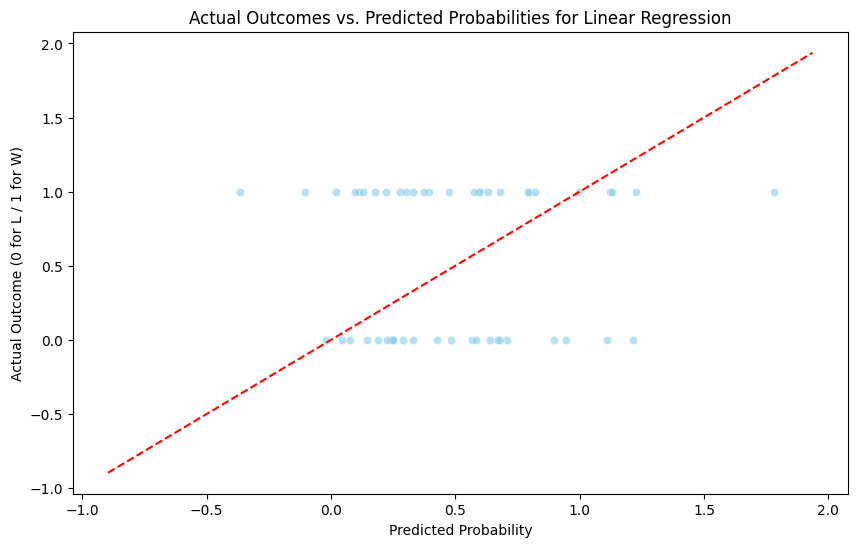

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Create a linear regression model and fit it to the training data
lr_model = LinearRegression()
lr_model.fit(X_train_preprocessed, y_train)

# Use the trained model to predict the NBA championship winner based on the test data
y_pred_lr = lr_model.predict(X_test_preprocessed)

# Get the team names from the original dataset for the test set
team_names_test = season_data.loc[X_test.index, 'TEAM_NAME'].reset_index(drop=True)
game_ids_test = season_data.loc[X_test.index, 'GAME_ID'].reset_index(drop=True)

# Create a DataFrame with team names and predicted probabilities for linear regression
probabilities_df_lr = pd.DataFrame({'GAME_ID': game_ids_test,'TEAM_NAME': team_names_test, 'Probability': y_pred_lr})

# Remove duplicates from df1 based on 'player_name' column
team_abbrev_unique = season_data.drop_duplicates(subset='TEAM_ABBREVIATION')

# Perform the merge between probabilities_df_lr and team_abbrev_unique to add abbreviations
probabilities_df_lr = probabilities_df_lr.merge(team_abbrev_unique[['TEAM_NAME', 'TEAM_ABBREVIATION']], on='TEAM_NAME', how='left')

# Remove duplicates from df1 based on 'player_name' column
game_matchups = data_encoded.drop_duplicates(subset='GAME_ID')

# Perform the merge between probabilities_df_lr and game_matchups to add matchups
probabilities_df_lr = probabilities_df_lr.merge(game_matchups[['GAME_ID', 'MATCHUP','GAME_DATE']], on='GAME_ID', how='left')

# Map probabilities to binary outcomes (W or L) based on a threshold of 0.5
probabilities_df_lr['Prediction'] = probabilities_df_lr['Probability'].apply(lambda x: 'W' if x >= 0.5 else 'L')

# Reset the index of probabilities_df_lr for proper display
probabilities_df_lr.reset_index(drop=True, inplace=True)

# Sort the DataFrame by probabilities in descending order for linear regression
probabilities_df_lr = probabilities_df_lr.sort_values('Probability', ascending=False)

# Print the table of teams with their probabilities for linear regression
print("Linear Regression Predictions:")
print(probabilities_df_lr)

# Evaluate the accuracy of the model using mean squared error and R-squared
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

print(f"LR R-squared: {r2_lr:.2f}")
print(f"LR Mean squared error: {mse_lr:.2f}")
print(f"Linear Regression RMSE: {rmse_lr:.2f}")

import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the scatter plot and the linear line for the predicted probabilities
plt.figure(figsize=(10, 6))

# Scatter plot for actual outcomes (W or L) against predicted probabilities
sns.scatterplot(x='Probability', y=(y_test == 1).astype(int), data=probabilities_df_lr, color='skyblue', alpha=0.6)

# Drawing the linear line for the predicted probabilities
sns.lineplot(x='Probability', y='Probability', data=probabilities_df_lr, color='red', linestyle='--')

plt.xlabel('Predicted Probability')
plt.ylabel('Actual Outcome (0 for L / 1 for W)')
plt.title('Actual Outcomes vs. Predicted Probabilities for Linear Regression')
plt.show()


Logistic Regression Accuracy: 0.9962335216572504
Logistic Regression Precision: 0.9969947407963937
Logistic Regression Recall: 0.9954988747186797
Logistic Regression F1-score: 0.9962462462462462
Logistic Regression Confusion Matrix:
[[1318    4]
 [   6 1327]]
AUC for Logistic Regression: 0.9994348057513622


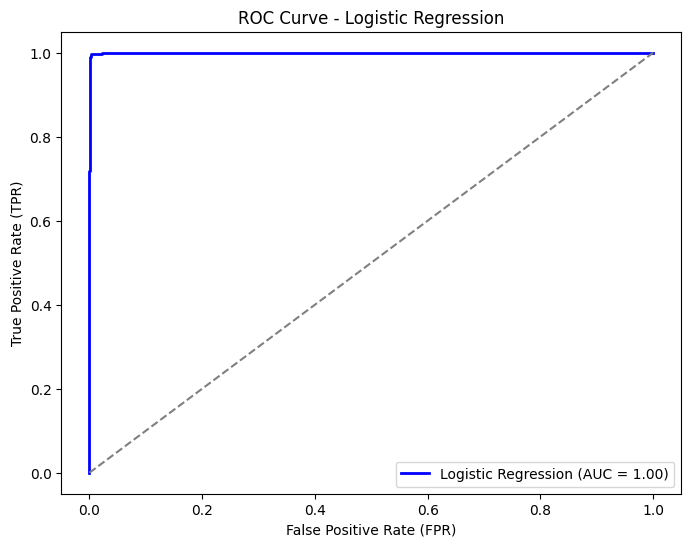

In [16]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train_preprocessed, y_train)

# Predict using the Logistic Regression model
y_pred_logreg = logreg_model.predict(X_test_preprocessed)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate metrics for Logistic Regression
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_precision = precision_score(y_test, y_pred_logreg)
logreg_recall = recall_score(y_test, y_pred_logreg)
logreg_f1 = f1_score(y_test, y_pred_logreg)
logreg_confusion_matrix = confusion_matrix(y_test, y_pred_logreg)

print("Logistic Regression Accuracy:", logreg_accuracy)
print("Logistic Regression Precision:", logreg_precision)
print("Logistic Regression Recall:", logreg_recall)
print("Logistic Regression F1-score:", logreg_f1)
print("Logistic Regression Confusion Matrix:")
print(logreg_confusion_matrix)


from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class (class 1)
y_pred_prob_logreg = logreg_model.predict_proba(X_test_preprocessed)[:, 1]

# Calculate the false positive rate (FPR) and true positive rate (TPR) for different probability thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_logreg)

# Calculate the AUC (Area Under the Curve) for the ROC curve
auc_score_logreg = roc_auc_score(y_test, y_pred_prob_logreg)
print("AUC for Logistic Regression:", auc_score_logreg)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Logistic Regression (AUC = {auc_score_logreg:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line representing random chance
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()


#results info
#The accuracy of the SVM model is approximately 0.50 or 50%. This means that the model is correctly predicting the outcome for only about half of the instances in the test set.
#Precision is a metric that measures the accuracy of positive predictions made by the model.
#Recall, also known as sensitivity or true positive rate, measures the model's ability to correctly identify positive instances out of all the actual positive instances. 
#The F1-score is the harmonic mean of precision and recall and provides a balance between the two metrics.

Random Forest Accuracy: 0.9958568738229755
Random Forest Precision: 0.9969924812030075
Random Forest Recall: 0.994748687171793
Random Forest F1-score: 0.9958693203154337
Random Forest Confusion Matrix:
[[1318    4]
 [   7 1326]]


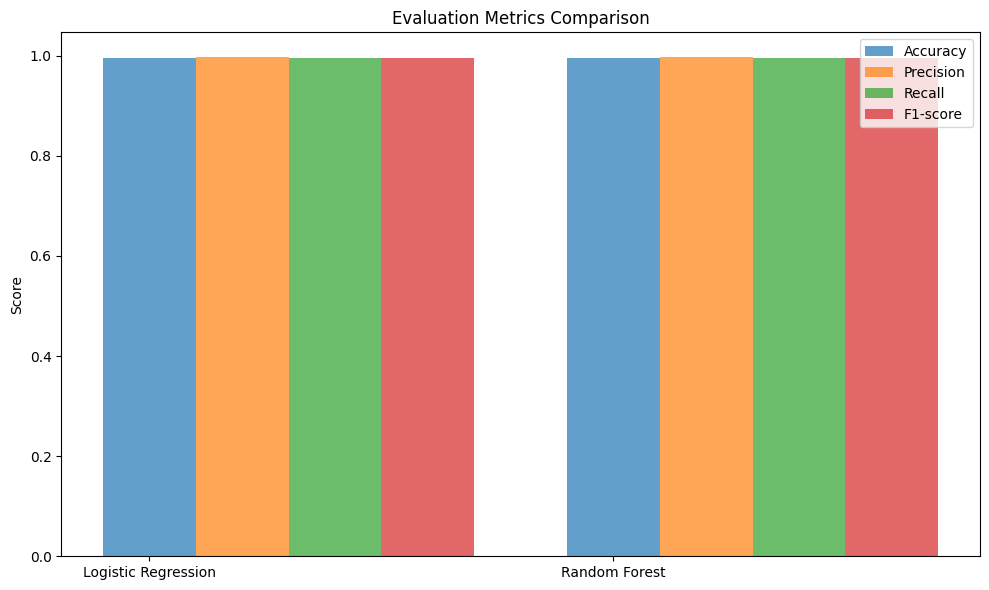

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#For Random Forest, feature scaling is generally not required, and it is one of the algorithms that is inherently robust to varying scales of features. 
# The reason behind this is that decision trees, which form the basis of the Random Forest algorithm, make splits based on comparisons of individual 
# features at each node. These splits are chosen based on the feature values that optimize certain criteria (e.g., Gini impurity or information gain) to separate the data effectively.

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier with desired hyperparameters
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train_preprocessed, y_train)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test_preprocessed)

# Calculate evaluation metrics for the Random Forest model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_confusion_matrix = confusion_matrix(y_test, y_pred_rf)

# Print the evaluation metrics
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Precision:", rf_precision)
print("Random Forest Recall:", rf_recall)
print("Random Forest F1-score:", rf_f1)
print("Random Forest Confusion Matrix:")
print(rf_confusion_matrix)

import matplotlib.pyplot as plt

# List of evaluation metrics and their values for both models
models = ['Logistic Regression', 'Random Forest']
accuracy = [logreg_accuracy, rf_accuracy]
precision = [logreg_precision, rf_precision]
recall = [logreg_recall, rf_recall]
f1 = [logreg_f1, rf_f1]

# Plot the evaluation metrics for both models
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(models))

ax.bar(x, accuracy, width=0.2, align='center', label='Accuracy', alpha=0.7)
ax.bar([i + 0.2 for i in x], precision, width=0.2, align='center', label='Precision', alpha=0.7)
ax.bar([i + 0.4 for i in x], recall, width=0.2, align='center', label='Recall', alpha=0.7)
ax.bar([i + 0.6 for i in x], f1, width=0.2, align='center', label='F1-score', alpha=0.7)

# Set labels and title
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics Comparison')
ax.legend()

plt.tight_layout()
plt.show()

#results info
#The accuracy of the SVM model is approximately 0.50 or 50%. This means that the model is correctly predicting the outcome for only about half of the instances in the test set.
#Precision is a metric that measures the accuracy of positive predictions made by the model.
#Recall, also known as sensitivity or true positive rate, measures the model's ability to correctly identify positive instances out of all the actual positive instances. 
#The F1-score is the harmonic mean of precision and recall and provides a balance between the two metrics.


Gradient Boosting Accuracy: 0.9966101694915255
Gradient Boosting Precision: 0.996996996996997
Gradient Boosting Recall: 0.9962490622655664
Gradient Boosting F1-score: 0.9966228893058161
Gradient Boosting Confusion Matrix:
[[1318    4]
 [   5 1328]]


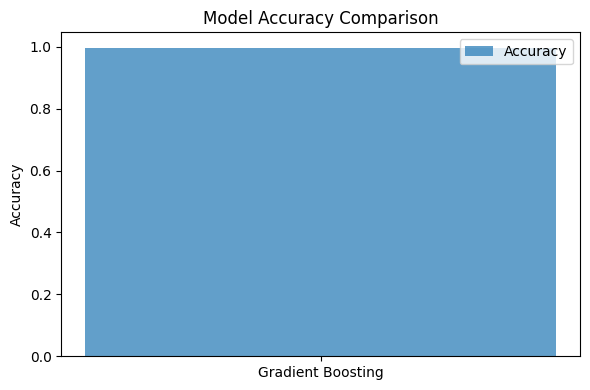

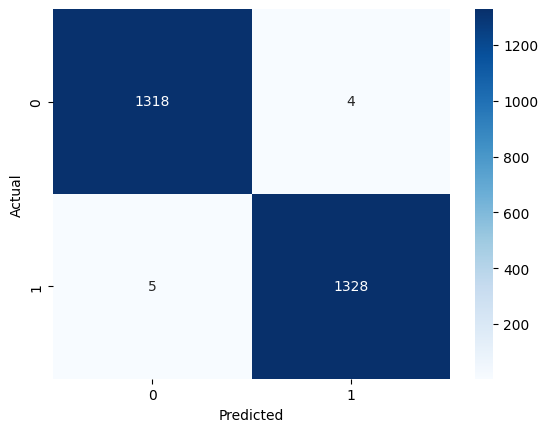

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

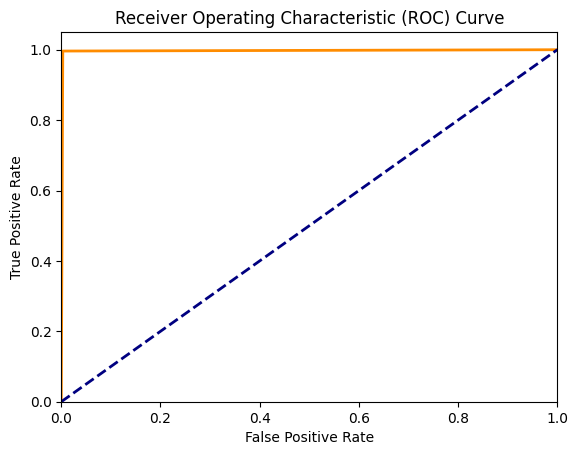

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler: MinMaxScaler is great for gradient descent-based algorithms
#Scaling for Gradient Descent-based algorithms (e.g., Linear Regression): For gradient descent algorithms, scaling can improve convergence speed.
#  impprove the performance of the model (by .1% so far)
scaler_gd = MinMaxScaler()

# Fit and transform the data using the scaler
data_scaled_gd = scaler_gd.fit_transform(X)

#print("Scaled data for Gradient Descent-based algorithms:")
#print(data_scaled_gd)


# Assuming you have already prepared the X (features) and y (target) data
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Gradient Boosting Classifier model and fit it to the training data
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train_preprocessed, y_train)

# Use the trained model to predict the NBA championship winner based on the test data
y_pred_gb = gb_model.predict(X_test_preprocessed)

# Calculate metrics for Gradient Boosting
gb_accuracy = accuracy_score(y_test, y_pred_gb)
gb_precision = precision_score(y_test, y_pred_gb)
gb_recall = recall_score(y_test, y_pred_gb)
gb_f1 = f1_score(y_test, y_pred_gb)
gb_confusion_matrix = confusion_matrix(y_test, y_pred_gb)

# Print the evaluation metrics
print("Gradient Boosting Accuracy:", gb_accuracy)
print("Gradient Boosting Precision:", gb_precision)
print("Gradient Boosting Recall:", gb_recall)
print("Gradient Boosting F1-score:", gb_f1)
print("Gradient Boosting Confusion Matrix:")
print(gb_confusion_matrix)
#results info
#The accuracy of the SVM model is approximately 0.50 or 50%. This means that the model is correctly predicting the outcome for only about half of the instances in the test set.
#Precision is a metric that measures the accuracy of positive predictions made by the model.
#Recall, also known as sensitivity or true positive rate, measures the model's ability to correctly identify positive instances out of all the actual positive instances. 
#The F1-score is the harmonic mean of precision and recall and provides a balance between the two metrics.

import matplotlib.pyplot as plt

# List of model names and their accuracy scores
models = ['Gradient Boosting']
accuracy = [gb_accuracy]

# Plot the accuracy scores
fig, ax = plt.subplots(figsize=(6, 4))
x = range(len(models))

ax.bar(x, accuracy, width=0.4, align='center', label='Accuracy', alpha=0.7)

# Set labels and title
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison')
ax.legend()

plt.tight_layout()
plt.show()

# Plot the confusion matrix using Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix for the predictions made by the model
cm = confusion_matrix(y_test, y_pred_gb)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate and true positive rate for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_gb)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')



You can use a learning curve graph to visualize whether a model is underfitting or overfitting. A learning curve graph plots the training and validation scores of a model as a function of the number of training examples.

If a model is underfitting, both the training and validation scores will be low and close to each other, indicating that the model is not complex enough to capture the underlying patterns in the data. In this case, adding more training examples is unlikely to improve the performance of the model.

If a model is overfitting, the training score will be high and the validation score will be low, indicating that the model is too complex and is fitting the noise in the training data. In this case, adding more training examples may help to improve the performance of the model.

Here's an example code snippet that shows how to plot a learning curve graph using scikit-learn:



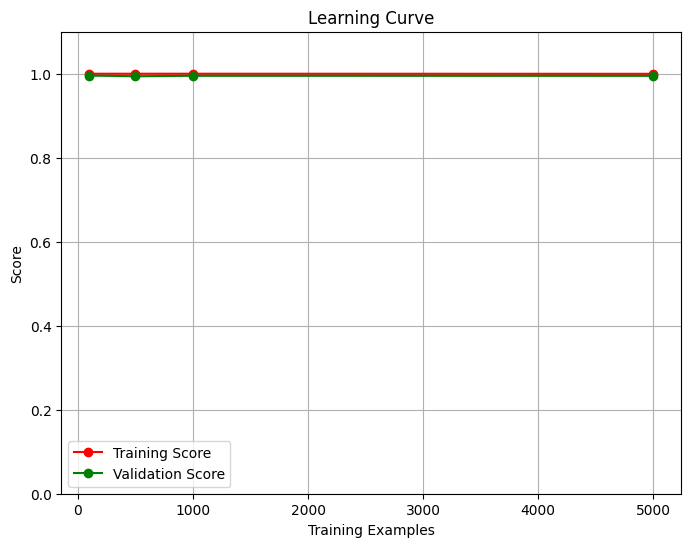

Cross-validation scores: [0.9952919  0.99293785 0.99340866 0.99623352 0.99481865]
Mean score: 0.9945381185172174
Standard deviation: 0.0012130787557808414


In [19]:
from sklearn.model_selection import learning_curve

# Define the model and the training set sizes
model = GradientBoostingClassifier()
train_sizes = [100, 500, 1000, 5000]

# Calculate the learning curve scores
train_sizes, train_scores, validation_scores = learning_curve(
    model, X_train, y_train, train_sizes=train_sizes, cv=5)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.ylim(0.0, 1.1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color='r')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1,
                 color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
         label='Training Score')
plt.plot(train_sizes, validation_scores_mean, 'o-', color='g',
         label='Validation Score')

plt.legend(loc='best')
plt.show()

from sklearn.model_selection import cross_val_score

# Define the model
model = GradientBoostingClassifier()

# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5)

# Print the mean and standard deviation of the scores
print('Cross-validation scores:', scores)
print('Mean score:', np.mean(scores))
print('Standard deviation:', np.std(scores))



This code will plot a learning curve graph for the GradientBoostingClassifier model using the training and validation sets. The `learning_curve` function from scikit-learn is used to calculate the training and validation scores for different training set sizes. The `train_sizes` parameter specifies the number of training examples to use for each iteration. The `cv` parameter specifies the number of cross-validation folds to use.

The learning curve graph shows the training and validation scores as a function of the number of training examples. The shaded areas represent the standard deviation of the scores. If the training and validation scores are close together and low, the model is underfitting. If the training score is high and the validation score is low, the model is overfitting. If the training and validation scores are both high and close together, the model is performing well.

SVM Accuracy: 0.9887005649717514
SVM Precision: 0.9894815927873779
SVM Recall: 0.9879969992498124
SVM F1-score: 0.9887387387387387
SVM Confusion Matrix:
[[1308   14]
 [  16 1317]]


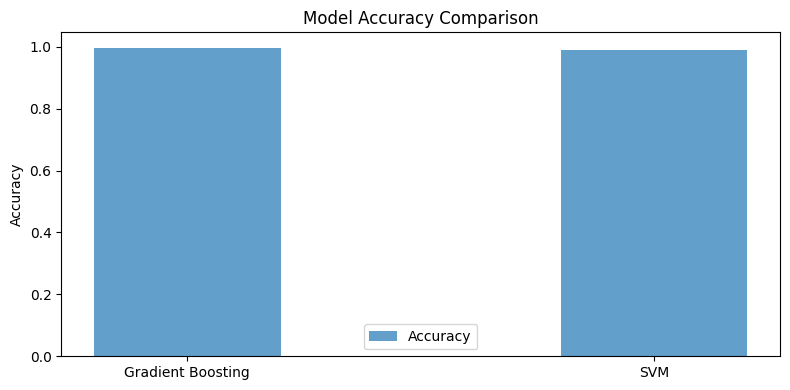

In [20]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Initialize the scaler: great for KNN and svm models
#scaler_svm = StandardScaler()

# Fit and transform the data using the scaler
#data_scaled_svm = scaler_svm.fit_transform(X)

#print("Scaled data for SVM:")
#print(data_scaled_svm)

# SVM model
svm_model = SVC()
svm_model.fit(X_train_preprocessed, y_train)

# Predict using the SVM model
y_pred_svm = svm_model.predict(X_test_preprocessed)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate metrics for SVM
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)
svm_confusion_matrix = confusion_matrix(y_test, y_pred_svm)

# Print the evaluation metrics
print("SVM Accuracy:", svm_accuracy)
print("SVM Precision:", svm_precision)
print("SVM Recall:", svm_recall)
print("SVM F1-score:", svm_f1)
print("SVM Confusion Matrix:")
print(svm_confusion_matrix)

#results info
#The accuracy of the SVM model is approximately 0.50 or 50%. This means that the model is correctly predicting the outcome for only about half of the instances in the test set.
#Precision is a metric that measures the accuracy of positive predictions made by the model.
#Recall, also known as sensitivity or true positive rate, measures the model's ability to correctly identify positive instances out of all the actual positive instances. 
#The F1-score is the harmonic mean of precision and recall and provides a balance between the two metrics.

# List of model names and their accuracy scores
models = ['Gradient Boosting', 'SVM']
accuracy = [gb_accuracy, svm_accuracy]

# Plot the accuracy scores
fig, ax = plt.subplots(figsize=(8, 4))
x = range(len(models))

ax.bar(x, accuracy, width=0.4, align='center', label='Accuracy', alpha=0.7)

# Set labels and title
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison')
ax.legend()

plt.tight_layout()
plt.show()


Accuracy: 0.8806026365348399
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88      1322
           1       0.88      0.88      0.88      1333

    accuracy                           0.88      2655
   macro avg       0.88      0.88      0.88      2655
weighted avg       0.88      0.88      0.88      2655

Confusion Matrix:
 [[1170  152]
 [ 165 1168]]


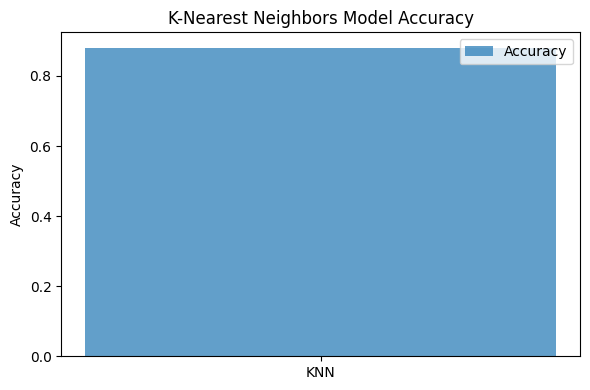

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load your dataset (data_encoded_selected) with historical NBA game data, including features and labels (WL_encoded)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_preprocessed)
X_test_scaled = scaler.transform(X_test_preprocessed)

# Create and train the K-nearest neighbors model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors (k) as needed
knn_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report_str)
print("Confusion Matrix:\n", conf_matrix) 
# Confusion matrix explained: top left is true positive, top right is false postive, bottom left is false negative, bottom right is true negative

# Plot the accuracy score
plt.figure(figsize=(6, 4))
plt.bar(['KNN'], [accuracy], width=0.4, align='center', label='Accuracy', alpha=0.7)

# Set labels and title
plt.ylabel('Accuracy')
plt.title('K-Nearest Neighbors Model Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



XGBoost Accuracy: 0.9954802259887006
XGBoost Precision: 0.9954988747186797
XGBoost Recall: 0.9954988747186797
XGBoost F1-score: 0.9954988747186797
XGBoost Confusion Matrix:
[[1316    6]
 [   6 1327]]


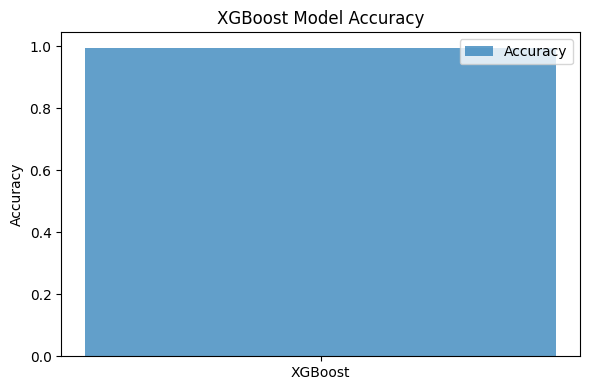

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Assuming you have already prepared the X (features) and y (target) data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost classifier model
xgb_model = XGBClassifier()

# Hyperparameter tuning options
# Uncomment one of the following blocks to choose the tuning method

# Option 1: Grid Search (specify the hyperparameter grid)
#Grid Search: This method searches exhaustively through a specified parameter grid. It provides a comprehensive exploration of the hyperparameter space but can be computationally expensive, especially with many hyperparameters.
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [100, 200, 300],
#     'min_child_weight': [1, 3, 5],
#     'gamma': [0, 0.1, 0.2]
# }
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5)
# grid_search.fit(X_train, y_train)
# xgb_model = grid_search.best_estimator_

# Option 2: Randomized Search (specify the hyperparameter distributions)
#Randomized Search: This method searches randomly through a specified parameter distribution. It provides a good exploration of the hyperparameter space and is less computationally expensive than Grid Search. However, it may not find the optimal hyperparameters.
param_distributions = {
     'max_depth': [3, 5, 7, 10],
     'learning_rate': [0.1, 0.01, 0.001],
     'n_estimators': [100, 200, 300, 400],
     'min_child_weight': [1, 3, 5],
     'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}
randomized_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions,
                                        scoring='accuracy', cv=5, n_iter=10, random_state=42)
randomized_search.fit(X_train_preprocessed, y_train)
xgb_model = randomized_search.best_estimator_

# Note: Uncomment only one of the above options for hyperparameter tuning.

# Train the model on the training data
#xgb_model.fit(X_train_preprocessed, y_train)

# Use the trained model to make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test_preprocessed)

# Calculate metrics for XGBoost
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_precision = precision_score(y_test, y_pred_xgb)
xgb_recall = recall_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_confusion_matrix = confusion_matrix(y_test, y_pred_xgb)

# Print the evaluation metrics
print("XGBoost Accuracy:", xgb_accuracy)
print("XGBoost Precision:", xgb_precision)
print("XGBoost Recall:", xgb_recall)
print("XGBoost F1-score:", xgb_f1)
print("XGBoost Confusion Matrix:")
print(xgb_confusion_matrix)

# Plot the accuracy score
plt.figure(figsize=(6, 4))
plt.bar(['XGBoost'], [xgb_accuracy], width=0.4, align='center', label='Accuracy', alpha=0.7)

# Set labels and title
plt.ylabel('Accuracy')
plt.title('XGBoost Model Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [23]:
import plotly.graph_objects as go

# List of evaluation metrics and their values for both models
models = ['Logistic Regression', 'Random Forest']
accuracy = [logreg_accuracy, rf_accuracy]
precision = [logreg_precision, rf_precision]
recall = [logreg_recall, rf_recall]
f1 = [logreg_f1, rf_f1]

# Create a figure with subplots
fig = go.Figure()

# Add traces for each evaluation metric
fig.add_trace(go.Bar(x=models, y=accuracy, name='Accuracy', marker_color='blue'))
fig.add_trace(go.Bar(x=models, y=precision, name='Precision', marker_color='green'))
fig.add_trace(go.Bar(x=models, y=recall, name='Recall', marker_color='orange'))
fig.add_trace(go.Bar(x=models, y=f1, name='F1-score', marker_color='red'))

# Update layout
fig.update_layout(title='Evaluation Metrics Comparison',
                  xaxis_title='Models',
                  yaxis_title='Score',
                  barmode='group',
                  legend=dict(x=0.1, y=1.2),
                  font=dict(size=12)
                  )

# Show the interactive plot
fig.show()
